# Speech Command Recognition

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
%pip install librosa -q

In [2]:

useColab=True
if useColab:
    # Use tensorflow 2.10 or 2.11
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/requirements.txt
    #!pip install -r requirements.txt
    !pip install tensorflow==2.19.0
    !pip install pandas>=0.25 tqdm librosa matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 w

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils

In [5]:
inp = tf.zeros( (2, 16000), dtype=tf.float32)
inp.shape
# audioUtils.normalized_mel_spectrogram( )

TensorShape([2, 16000])

In [6]:
inp * 3

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [7]:
stft = tf.signal.stft(
    inp,
    frame_length=1024,
    frame_step=128,
    window_fn=tf.signal.hann_window,
    pad_end=True,
)
stft.shape

TensorShape([2, 125, 513])

In [8]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

110kKB [00:01, 96.4kKB/s]                         


2.37MKB [00:40, 58.0kKB/s]                          


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/
Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:03<00:00, 1268.54it/s]


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:10<00:00, 810.89it/s] 


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [9]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [10]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [11]:
audios, classes = valGen.__getitem__(5)
classes

array([ 6,  9, 27,  9, 11, 32, 20,  7, 12,  3,  1, 14, 14,  5,  4,  3, 20,
        1, 14, 11, 23, 14, 19,  8, 10,  8, 10, 35, 27,  3,  5,  7])

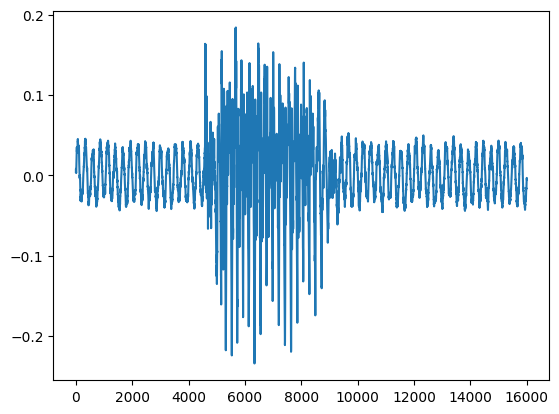

In [12]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model
from tensorflow.keras import layers

class NormalizedMelSpectrogramLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return audioUtils.normalized_mel_spectrogram(inputs)


inp = L.Input((iLen,), name='input')
mel_spec = NormalizedMelSpectrogramLayer()(inp)
melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalized_spectrogram_model')

melspecModel.summary()

Model: "normalized_spectrogram_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalized_mel_spectrogram_lay… │ (None, 125, 80)        │             0 │
│ (NormalizedMelSpectrogramLayer) │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
audios.shape

(32, 16000)

In [15]:
melspec = melspecModel.predict(audios)
melspec.shape

np.min(melspec[9,:,:].T), np.max(melspec[9,:,:].T), np.mean(melspec[9,:,:].T)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(np.float32(-1.2010225), np.float32(2.2275703), np.float32(0.20842153))

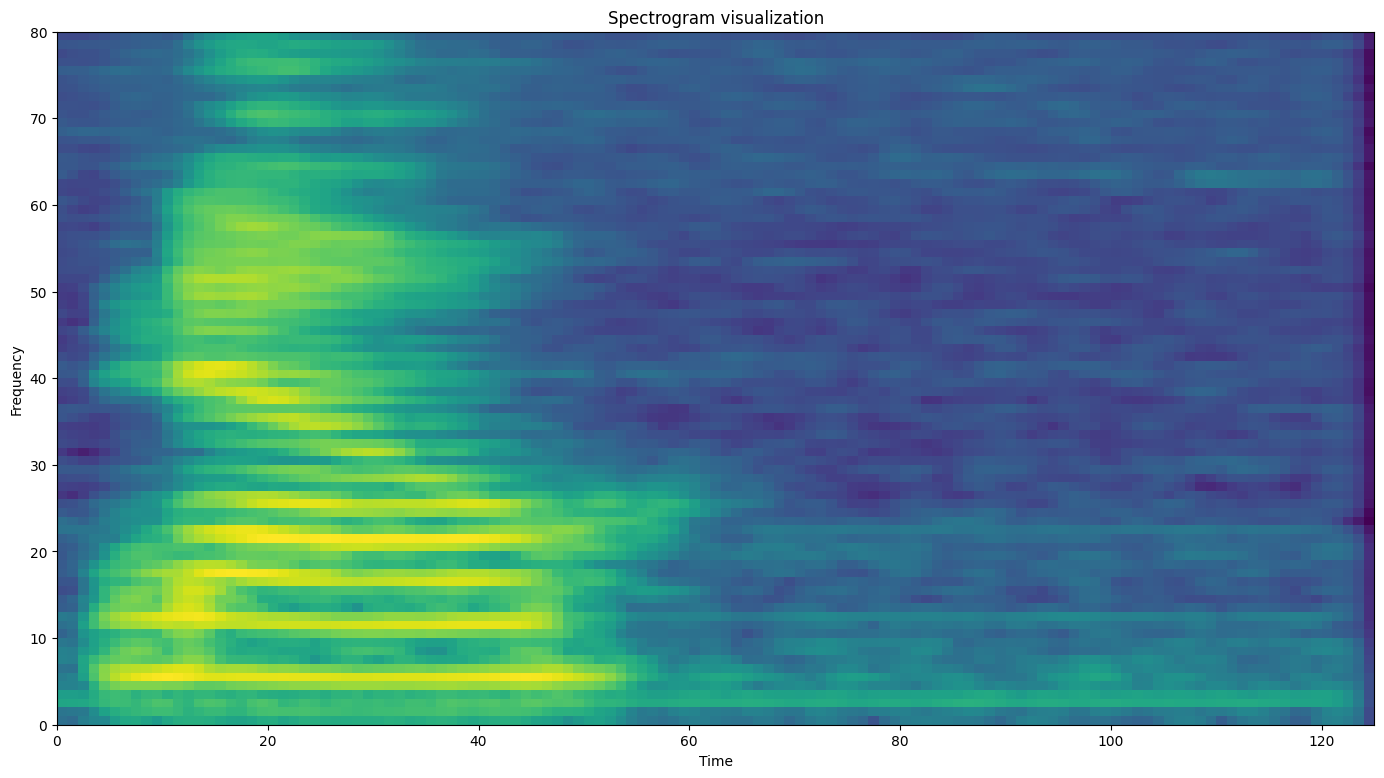

In [16]:
plt.figure(figsize=(17,9))
plt.pcolormesh(melspec[9,:,:].T)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [17]:
import librosa

# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
np.min(S_dB), np.max(S_dB)

(np.float64(-44.819286633510146), np.float64(0.0))

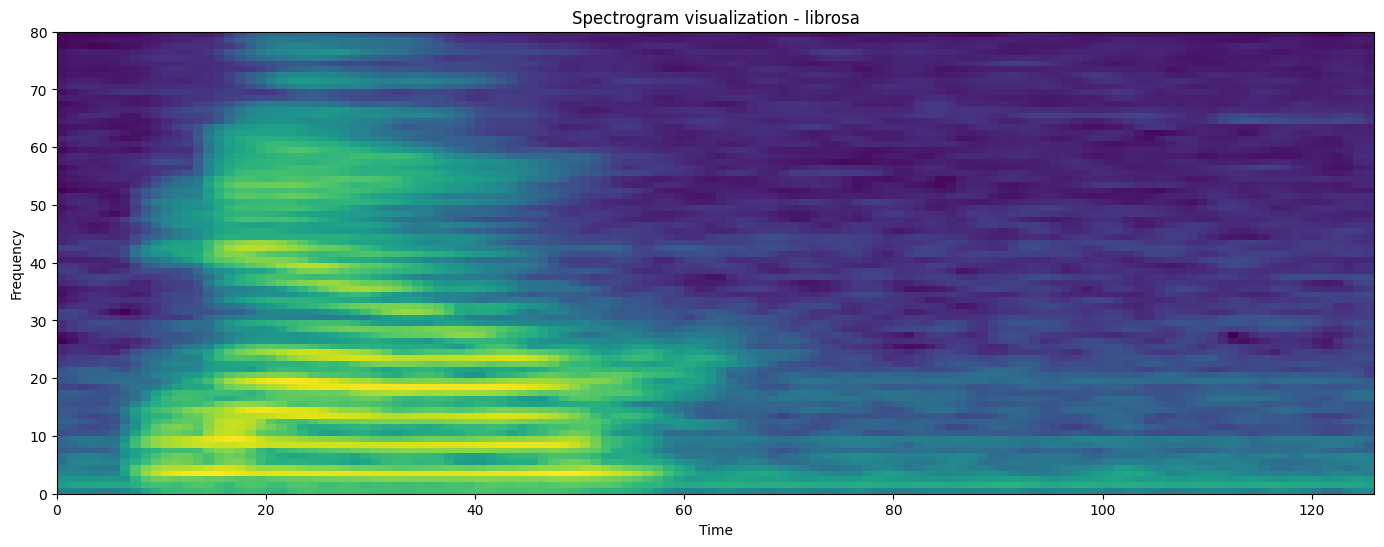

In [18]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [19]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [26]:
from tensorflow.keras.models import Model, load_model

In [27]:
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalized_spectro… │ (None, None, 80)  │          0 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_stft (Lambda)   │ (None, None, 80,  │          0 │ normalized_spect… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None, 80,  │         60 │ mel_stft[0][0]    │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 80,  │         40 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None, 80,  │         51 │ batch_normalizat… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 80,  │          4 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_last_dim    │ (None, None, 80)  │          0 │ batch_normalizat… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, None, 128) │     74,240 │ squeeze_last_dim… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, None, 128) │     98,816 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, None)      │          0 │ dense_3[0][0],    │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attSoftmax          │ (None, None)      │          0 │ dot_2[0][0]       │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 128)       │          0 │ attSoftmax[0][0], │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 36)        │      1,188 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,247 (786.12 KB)

 Trainable params: 201,225 (786.04 KB)

 Non-trainable params: 22 (88.00 B)

In [28]:
# model.load_weights('model-attRNN.h5')

In [29]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy',
                               verbose=1, save_best_only=True)

results = model.fit(trainGen,
                    validation_data=valGen,
                    epochs=60,
                    verbose=1,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.keras')


Changing learning rate to 0.001
Epoch 1/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.3961 - sparse_categorical_accuracy: 0.6060
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.89459, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 175s 41ms/step - loss: 1.3959 - sparse_categorical_accuracy: 0.6061 - val_loss: 0.3657 - val_sparse_categorical_accuracy: 0.8946 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 2/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3253 - sparse_categorical_accuracy: 0.9046
Epoch 2: val_sparse_categorical_accuracy improved from 0.89459 to 0.92886, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 97s 37ms/step - loss: 0.3253 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.2492 - val_sparse_categorical_accuracy: 0.9289 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 3/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.9279
Epoch 3: val_sparse_categorical_accuracy improved from 0.92886 to 0.93338, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 106s 40ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.9279 - val_loss: 0.2228 - val_sparse_categorical_accuracy: 0.9334 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 4/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1863 - sparse_categorical_accuracy: 0.9434
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.93338
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 103s 39ms/step - loss: 0.1863 - sparse_categorical_accuracy: 0.9434 - val_loss: 0.2364 - val_sparse_categorical_accuracy: 0.9307 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 5/60
2650/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9505
Epoch 5: val_sparse_categorical_accuracy improved from 0.93338 to 0.93559, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 104s 39ms/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.2193 - val_sparse_categorical_accuracy: 0.9356 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 6/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1334 - sparse_categorical_accuracy: 0.9588
Epoch 6: val_sparse_categorical_accuracy improved from 0.93559 to 0.94463, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 135s 36ms/step - loss: 0.1334 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.1975 - val_sparse_categorical_accuracy: 0.9446 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 7/60
2650/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9634
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.94463
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.2448 - val_sparse_categorical_accuracy: 0.9354 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 8/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.9680
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.94463
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 96s 36ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.2048 - val_sparse_categorical_accuracy: 0.9435 - learning_rate: 0.0010
Changing learning rate to 0.0

2651/2651 ━━━━━━━━━━━━━━━━━━━━ 103s 39ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.9466 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 14/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0635 - sparse_categorical_accuracy: 0.9802
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.94664
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 96s 36ms/step - loss: 0.0635 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.2569 - val_sparse_categorical_accuracy: 0.9396 - learning_rate: 0.0010
Changing learning rate to 0.0004
Epoch 15/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9858
Epoch 15: val_sparse_categorical_accuracy improved from 0.94664 to 0.95066, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 101s 38ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.2281 - val_sparse_categorical_accuracy: 0.9507 - learning_rate: 4.0000e-04
Changing learning rate to 0.0004
Epoch 16/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0267 - sparse_categorical_accuracy: 0.9928
Epoch 16: val_sparse_categorical_accuracy improved from 0.95066 to 0.95207, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 100s 38ms/step - loss: 0.0267 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.2595 - val_sparse_categorical_accuracy: 0.9521 - learning_rate: 4.0000e-04
Changing learning rate to 0.0004
Epoch 17/60
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9930
Epoch 17: val_sparse_categorical_accuracy did not improve from 0.95207
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 94s 35ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.2854 - val_sparse_categorical_accuracy: 0.9486 - learning_rate: 4.0000e-04
Changing learning rate to 0.0004
Epoch 18/60
2650/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9935
Epoch 18: val_sparse_categorical_accuracy did not improve from 0.95207
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step - loss: 0.0223 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.2950 - val_sparse_categorical_accuracy: 0.9478 - learning_rate: 4.0000e-04
Changing lea

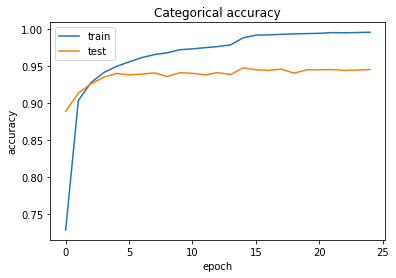

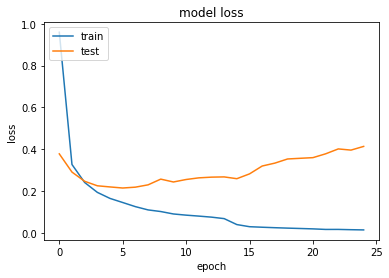

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# results.history

In [ ]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [ ]:
# tf.saved_model.save(model, 'model-KWS-attRNN')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.030799511820077896, 0.9913240075111389] 
Validation: [0.25848108530044556, 0.9480506181716919] 
Test: [0.2578895092010498, 0.9421172142028809]


In [ ]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [ ]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output,
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('tf.expand_dims').output])


In [ ]:
audios, classes = valGen.__getitem__(3)
classes

array([17, 12,  4,  5, 35, 21, 27,  8, 18, 11, 11, 20,  3,  1, 32, 22, 20,
       12,  1, 13, 15, 33, 23,  6, 32,  9, 32,  5, 20, 22, 18,  9])

In [ ]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

18

In [ ]:
outs, attW, specs = attSpeechModel.predict(audios)

1/1 [==============================] - 1s 1s/step


In [ ]:
np.argmax(outs,axis=1)

array([17, 12,  4,  5, 35,  5, 27,  8, 18, 16, 11, 20,  3,  1, 32, 22, 20,
       12,  1, 13, 15, 33, 23,  6, 32,  9, 32,  5, 20, 22, 18,  9])

In [ ]:
specs.shape

(32, 125, 80, 1)

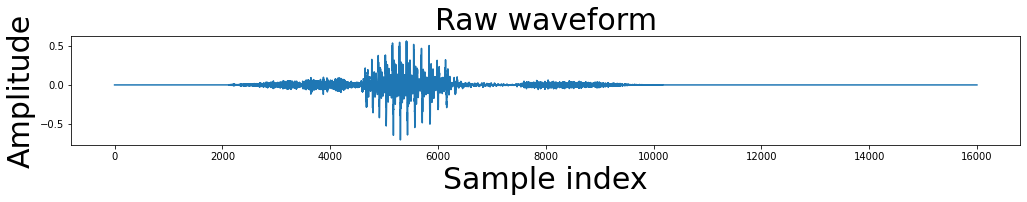

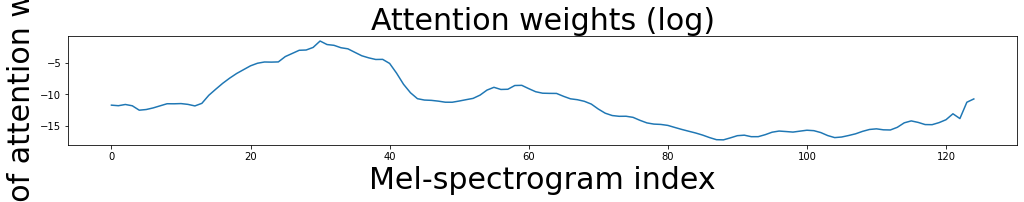

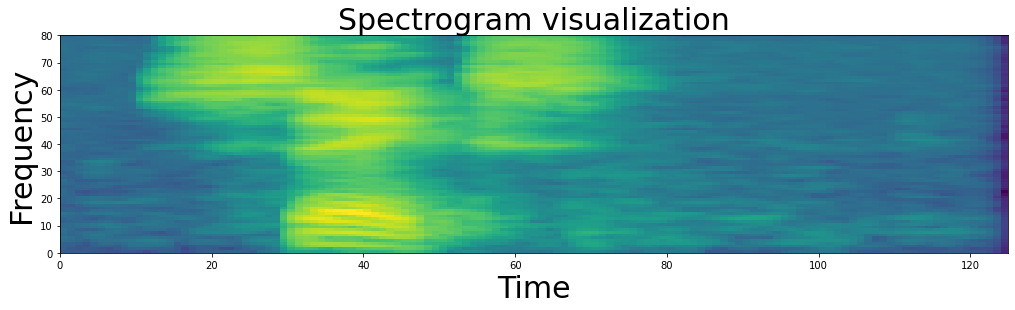

In [ ]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0].T)

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [ ]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 5s 10ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#set(y_test)

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six',
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [ ]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight',
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house',
#         'marvin', 'sheila', 'tree', 'wow']

In [ ]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


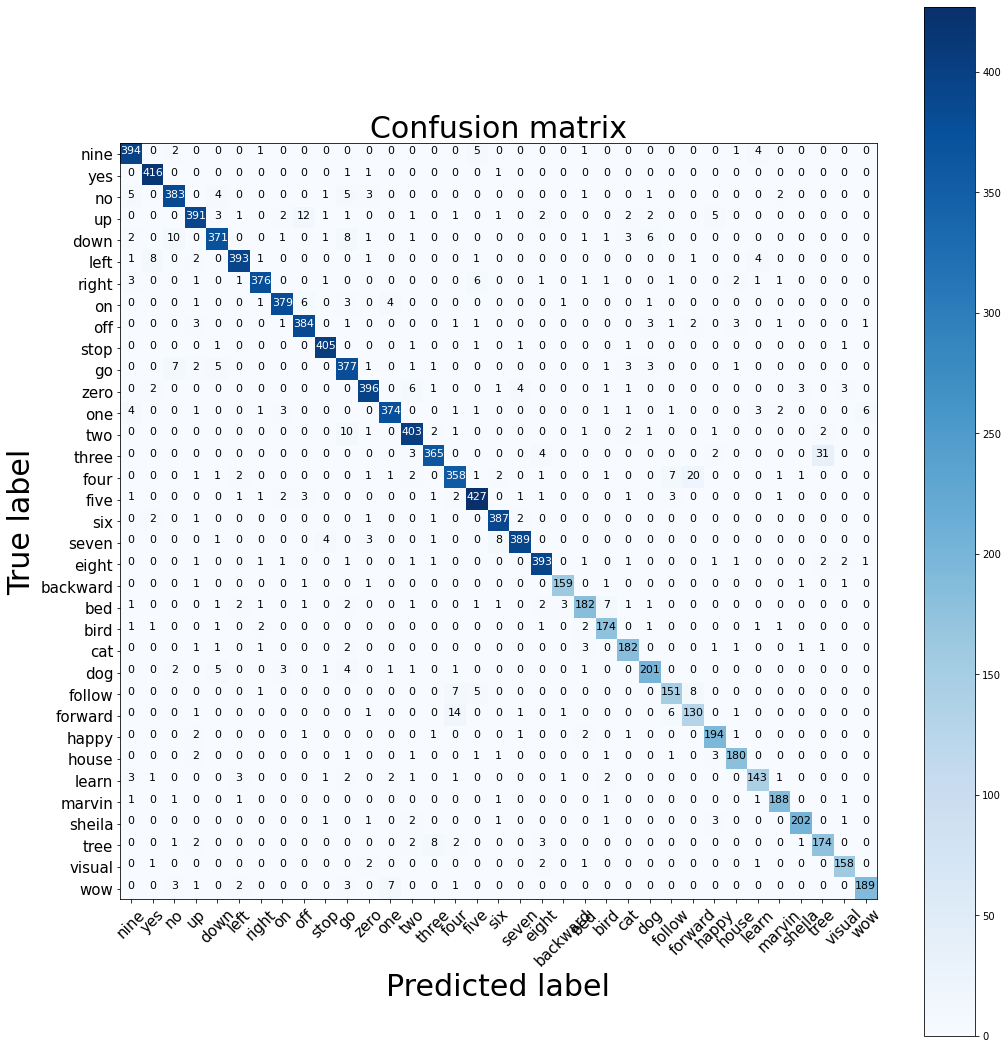

In [ ]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
import pandas as pd
[tf.__version__, pd.__version__, librosa.__version__]

['2.10.1', '1.5.2', '0.9.2']

# Save model

In [ ]:
model_16000 = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)
model_16000.load_weights('model-attRNN.h5')

tf.saved_model.save(model_16000, 'model-KWS-attRNN')

INFO:tensorflow:Assets written to: model-KWS-attRNN/assets


INFO:tensorflow:Assets written to: model-KWS-attRNN/assets


In [ ]:
model_16000 = tf.saved_model.load('model-KWS-attRNN')

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model-KWS-attRNN') # path to the SavedModel directory

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open('model-KWS-attRNN.tflite', 'wb') as f:
    f.write(tflite_model)